In [1]:
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install -r requirements.txt

  Using cached numpy-1.24.2-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
You should consider upgrading via the '/Users/jimchen/miniconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import joblib
from pydantic import BaseModel, Field
from pydantic.tools import parse_obj_as

In [3]:
test_dataset = pd.read_csv("https://cmu-313.github.io/assets/project/student_data.csv")
clf = joblib.load('./model.pkl')

<AxesSubplot:>

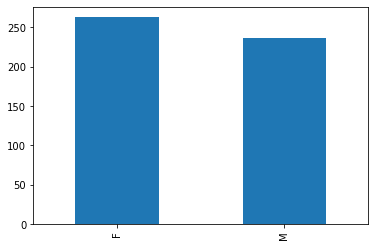

In [43]:
test_dataset['Gender'].value_counts().plot.bar()

<AxesSubplot:>

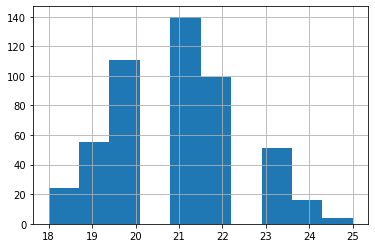

In [24]:
test_dataset['Age'].hist()

<AxesSubplot:>

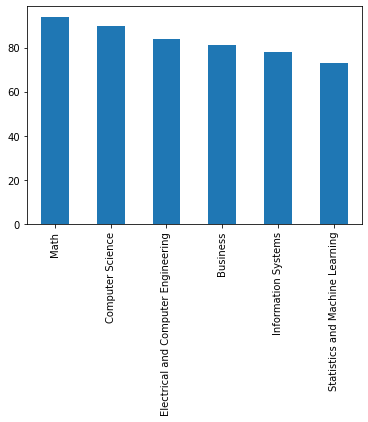

In [44]:
test_dataset['Major'].value_counts().plot.bar()

<AxesSubplot:>

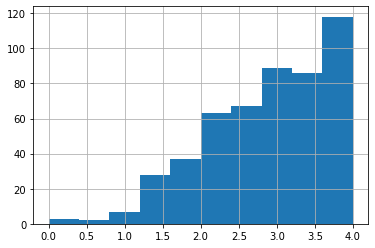

In [46]:
test_dataset['GPA'].hist()

<AxesSubplot:>

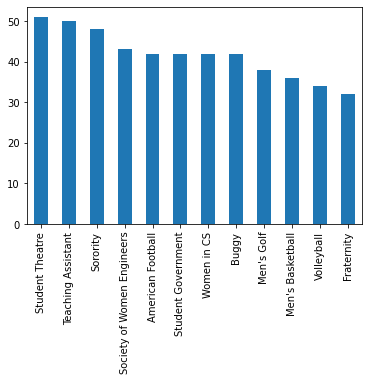

In [47]:
test_dataset['Extra Curricular'].value_counts().plot.bar()

<AxesSubplot:>

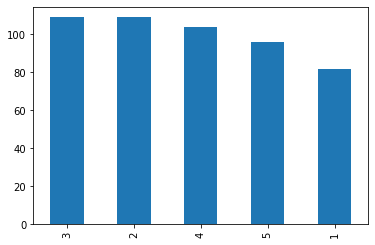

In [48]:
test_dataset['Num Programming Languages'].value_counts().plot.bar()

<Axes: >

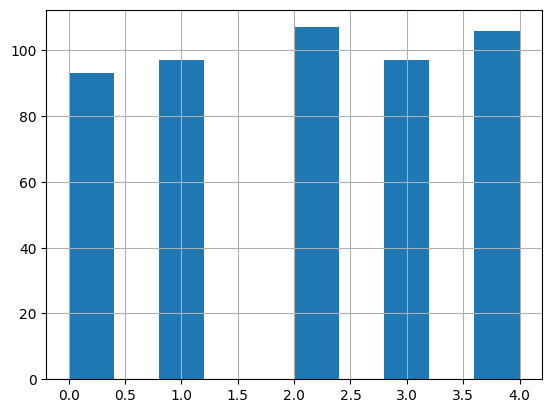

In [4]:
test_dataset['Num Past Internships'].hist()

<AxesSubplot:>

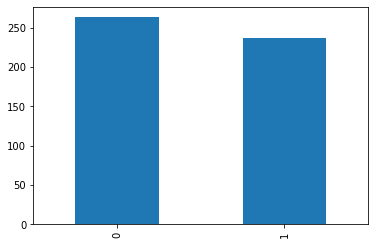

In [50]:
test_dataset['Good Candidate'].value_counts().plot.bar()

In [5]:
test_dataset.columns

Index(['Student ID', 'Gender', 'Age', 'Major', 'GPA', 'Extra Curricular',
       'Num Programming Languages', 'Num Past Internships', 'Good Candidate'],
      dtype='object')

In [6]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One Hot Encode',
                                                  OneHotEncoder(), [1, 3])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=1000))])

In [22]:
feature_cols = ['Student ID', 'Gender', 'Age', 'Major', 'GPA', 'Extra Curricular',
       'Num Programming Languages', 'Num Past Internships']
y_pred = clf.predict(test_dataset[feature_cols])
y_pred = pd.Series(y_pred)
y_pred

0      0
1      1
2      0
3      1
4      0
      ..
495    0
496    1
497    0
498    1
499    0
Length: 500, dtype: int64

In [12]:
y = test_dataset['Good Candidate']
y

0      0
1      0
2      0
3      0
4      0
      ..
495    0
496    1
497    0
498    1
499    0
Name: Good Candidate, Length: 500, dtype: int64

In [17]:
print(f"Test accuracy is {(y==y_pred).sum()/y.size:.4f}")

Test accuracy is 0.8320


In [19]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y, y_pred)
print("The confusion matrix is")
confusion_matrix

The confusion matrix is


array([[221,  42],
       [ 42, 195]])

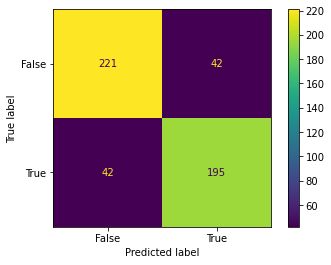

In [21]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

## 5. Fairness Evaluation

In [36]:
df_pred = pd.Series(y_pred, name='Predicted Good Candidate').to_frame()

df_pred

,Predicted Good Candidate
0,0
1,1
2,0
3,1
4,0
...,...
495,0
496,1
497,0
498,1


In [37]:
df = test_dataset.join(df_pred)

df

,Student ID,Gender,Age,Major,GPA,Extra Curricular,Num Programming Languages,Num Past Internships,Good Candidate,Predicted Good Candidate
0,0,F,21,Statistics and Machine Learning,2.83,Sorority,4,1,0,0
1,1,M,20,Information Systems,2.89,Fraternity,5,3,0,1
2,2,F,20,Math,2.66,Teaching Assistant,3,1,0,0
3,3,M,20,Information Systems,2.48,Fraternity,5,0,0,1
4,4,F,21,Statistics and Machine Learning,3.30,Sorority,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...
495,495,M,20,Computer Science,2.89,Student Government,5,0,0,0
496,496,F,24,Computer Science,2.53,Buggy,3,2,1,1
497,497,F,21,Computer Science,2.00,Sorority,3,2,0,0
498,498,M,22,Electrical and Computer Engineering,3.24,Men's Basketball,4,1,1,1


#### Demographic Parity on Gender

In [40]:
total_count_males = len(df[df['Gender'] == 'M'])
total_count_females = len(df[df['Gender'] == 'F'])

positive_males = len(df[(df['Predicted Good Candidate'] == 1)&(df['Gender'] == 'M')])
positive_females = len(df[(df['Predicted Good Candidate'] == 1)&(df['Gender'] == 'F')])

print('Positive Rate for Males: ', positive_males/total_count_males)
print('Positive Rate for Females: ', positive_females/total_count_females)

Positive Rate for Males:  0.6160337552742616
Positive Rate for Females:  0.34600760456273766


#### Equal Opportunity on Gender

In [48]:
# total_count_males = len(df[df['Gender'] == 'M'])
# total_count_females = len(df[df['Gender'] == 'F'])

positive_males = len(df[(df['Predicted Good Candidate'] == 1)&(df['Gender'] == 'M')])
positive_females = len(df[(df['Predicted Good Candidate'] == 1)&(df['Gender'] == 'F')])

print('Positive Rate for Males: ', positive_males/len(df))
print('Positive Rate for Females: ', positive_females/len(df))

Positive Rate for Males:  0.292
Positive Rate for Females:  0.182


#### Group Aware on Number of Programming Languages 

In [59]:
positive_predictions = len(df.loc[(df['Good Candidate'] == 1) & (df['Predicted Good Candidate'] == 1)])
total_predictions = len(df)

print('Positive Rate for Group Aware of Number of Programming Languages: ', positive_predictions/total_predictions)

Positive Rate for Group Aware of Number of Programming Languages:  0.39
